# 환경과 에이전트

예제 설명
* 환경(Environment) : 에이전트의 액션을 받아 상태변이를 일으키고, 보상을 줌 
    - 환경에 특별한 확률적 요소는 없음
    - 각 스텝마다 보상은 -1로 고정
* 에이전트(Agent) : 4방향 랜덤 정책을 이용해 움직임 
* 경험 쌓는 부분(1 Episode) : 에이전트가 환경과 상호작용하며 데이터를 축적 
* 학습하는 부분(Update) : 쌓인 경험을 통해 테이블을 업데이트

## Environment

(0,0)에서 출발하여 (3,3)에 도달하고자함

In [36]:
class GridWorld():
    def __init__(self): # 초기 위치 선정
        self.x=0
        self.y=0
    
    def step(self, a): # 핵심 함수 - 액션에 따른 상태 변이, 보상 정의, 종결 여부 판단
        # 4가지 action - 상하좌우
        if a==0:
            self.move_left()
        elif a==1:
            self.move_up()
        elif a==2:
            self.move_right()
        elif a==3:
            self.move_down()

        reward = -1 # 보상은 항상 -1
        done = self.is_done()
        return (self.x, self.y), reward, done

    def move_right(self): # Action에 따른 이동
        self.y += 1  
        if self.y > 3:
            self.y = 3
      
    def move_left(self): # Action에 따른 이동
        self.y -= 1
        if self.y < 0:
            self.y = 0
      
    def move_up(self): # Action에 따른 이동
        self.x -= 1
        if self.x < 0:
            self.x = 0
  
    def move_down(self): # Action에 따른 이동
        self.x += 1
        if self.x > 3:
            self.x = 3

    def is_done(self): # 에피소드가 끝났는지 판단
        if self.x == 3 and self.y == 3:
            return True
        else :
            return False

    def get_state(self): # 현재 위치 반환
        return (self.x, self.y)
      
    def reset(self): # 처음 상태로 되돌리기
        self.x = 0
        self.y = 0
        return (self.x, self.y)

## Agent

In [37]:
import random

class Agent():
    def __init__(self):
        pass

    def select_action(self): # 랜덤하게 액션을 선택하는 정책
        coin = random.random()

        # uniform 확률 분포의 형태
        if coin < 0.25:
            action = 0
        elif coin < 0.5:
            action = 1
        elif coin < 0.75:
            action = 2
        else:
            action = 3
        return action

In [38]:
from utils.function_time import logging_time
from utils.visualization import value_visualize

# 학습방법1. MCLearning

테이블 업데이트 : V(s) = V(s) + alpha * (G - V(s))

In [39]:
@logging_time
def monte_carlo(episode):
    env = GridWorld()
    agent = Agent()
    data = [[0] * 4 for _ in range(4)] # 4x4 크기의 0으로 채워진 2차원 리스트 생성 = 테이블이며 value 값 저장
    gamma = 1.0 # 할인율이 1이므로 리턴값은 도착할 때까지의 이동횟수를 의미
    alpha = 0.0001

    for n in range(5000) : # 에피소드 수만큼 반복
        done = False
        history = []
        # 경험 쌓는 부분
        while not done:
            action = agent.select_action() # 정책에 따라 액션 선택 : 현재 정책은 랜덤 선택
            (x,y), reward, done = env.step(action) # 액션에 따른 상태 변이
            history.append((x,y,reward)) # 에피소드의 상태, 보상 정보 저장
        #print("{} 번째 에피소드의 이동 횟수 : {}".format(n+1,len(history)))
        env.reset() # 에피소드가 끝나면 환경 초기화

        # 매 에피소드가 끝나고 바로 해당 데이터를 이용해 테이블을 업데이트
        cum_reward = 0 # 리턴값
        for transition in history[::-1]: # 방문했던 상태들을 뒤에서부터 보며 차례차례 리턴을 계산
            x, y, reward = transition
            data[x][y] = data[x][y] + alpha * (cum_reward - data[x][y]) # V(s) = V(s) + alpha * (G - V(s)) : 몬테카를로 방식
            cum_reward = reward + gamma * cum_reward # Gt = Rt + gamma * Gt+1 : 재귀적인 관계
        #print("{} 번째 에피소드의 리턴값 : {}".format(n+1,cum_reward))

        # 학습 500번마다 한 번씩 각 에피소드 결과 확인 및 해당 에피소드까지 업데이트된 Value 시각화
        if n % 500 == 0:
            print("{} 번째 에피소드의 이동 횟수 : {}".format(n+1,len(history)))
            print("{} 번째 에피소드의 리턴값 : {}".format(n+1,cum_reward))
            value_visualize(n, data)
    return data

Policy는 Random이기에 한 에피소드의 이동횟수이자 리턴값은 Random하지만, Value 값은 `data` 변수에 쌓이기 때문에 점차 수렴한다.

1 번째 에피소드의 이동 횟수 : 12
1 번째 에피소드의 리턴값 : -12.0


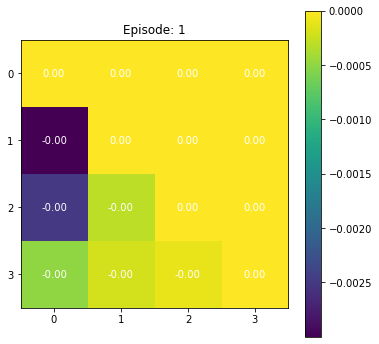

501 번째 에피소드의 이동 횟수 : 101
501 번째 에피소드의 리턴값 : -101.0


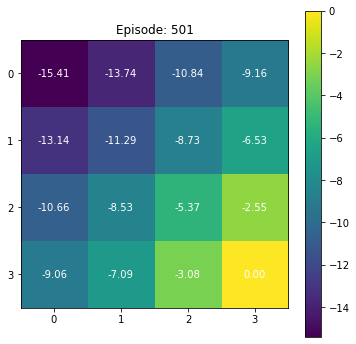

1001 번째 에피소드의 이동 횟수 : 38
1001 번째 에피소드의 리턴값 : -38.0


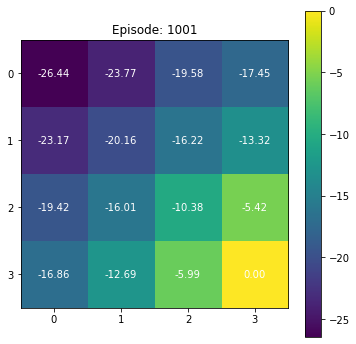

1501 번째 에피소드의 이동 횟수 : 112
1501 번째 에피소드의 리턴값 : -112.0


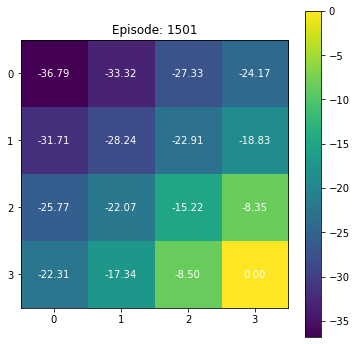

2001 번째 에피소드의 이동 횟수 : 39
2001 번째 에피소드의 리턴값 : -39.0


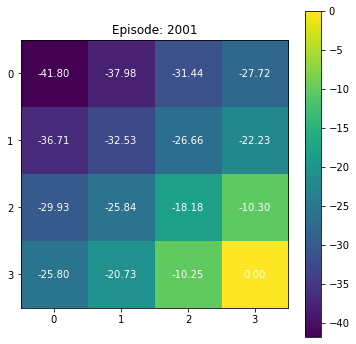

2501 번째 에피소드의 이동 횟수 : 24
2501 번째 에피소드의 리턴값 : -24.0


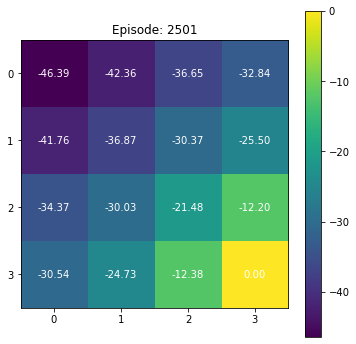

3001 번째 에피소드의 이동 횟수 : 45
3001 번째 에피소드의 리턴값 : -45.0


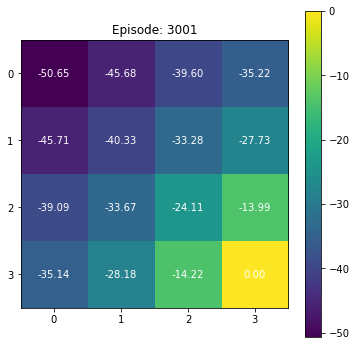

3501 번째 에피소드의 이동 횟수 : 26
3501 번째 에피소드의 리턴값 : -26.0


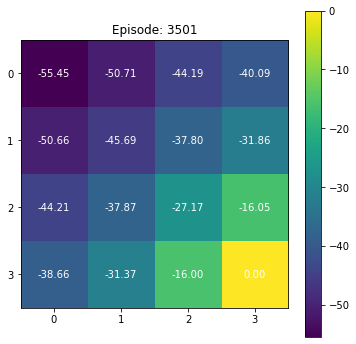

4001 번째 에피소드의 이동 횟수 : 36
4001 번째 에피소드의 리턴값 : -36.0


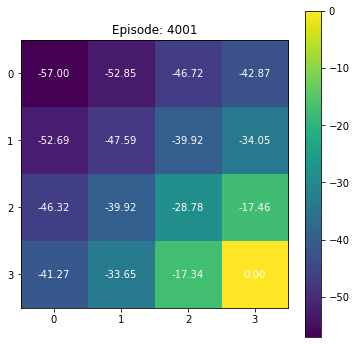

4501 번째 에피소드의 이동 횟수 : 81
4501 번째 에피소드의 리턴값 : -81.0


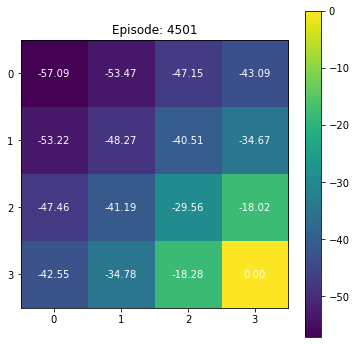

Running Time[monte_carlo]: 0.90088773 sec


In [40]:
episode = 5000 # 총 5000번의 에피소드 진행
MC_result = monte_carlo(episode)

랜덤으로 방향을 설정하는 정책 파이에 대한 Value 값은 다음과 같다.

[-58.1518817098625, -55.50203107395207, -49.4101759001578, -45.43001476674682]
[-54.47176089519253, -50.07653557270818, -42.46850542225603, -36.488997780464615]
[-48.56822864501431, -42.47497982481984, -30.89498419626018, -18.874090763200353]
[-42.785357645345265, -35.65494090987885, -19.012608931259734, 0.0]


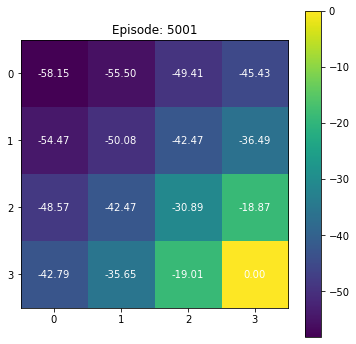

In [41]:
# 학습이 끝나고 난 후 데이터를 출력해보기 위한 코드
for row in MC_result:
    print(row)

# Value 시각화
value_visualize(episode, MC_result)

* MC Prediction 은 policy를 바꾸지 않고, 특정 policy를 수행하였을 때의 리턴값을 evaluation 한다.
* 단점 
    - 각 state 와 action의 관계를 전혀 활용하지 않는다. 
    - 업데이트를 하려면 에피소드가 끝날 때까지 기다려야 한다. -> 반드시 종료하는 MDP에서만 사용 가능

# 학습방법2. TDLearning

테이블 업데이트 : V(s) = V(s) + alpha * (Rt+1 + gamma * V(s+1) - V(s)) 

In [82]:
@logging_time
def temporal_difference():
    env = GridWorld()
    agent = Agent()
    data = [[0] * 4 for _ in range(4)]
    gamma = 1.0
    alpha = 0.01 # monte_carlo에서는 0.0001

    for k in range(5000): # 총 5000번의 에피소드 진행
        done = False
        while not done:
            x, y = env.get_state()
            action = agent.select_action()
            (x_prime, y_prime), reward, done = env.step(action)
            x_prime, y_prime = env.get_state()

            # 한 번의 step (action) 이 진행되자마자 바로 테이블의 데이터를 업데이트 해줌
            data[x][y] = data[x][y] + alpha * (reward + gamma * data[x_prime][y_prime] - data[x][y]) # TD 방식
            # print("좌표값 : ({}, {}) / TD타겟값 : {}".format(x, y, data[x][y]))
        env.reset()

        if k % 500 == 0:
            print("{} 번째 에피소드의 TD타겟값 : {}".format(k+1, data[x][y]))
            value_visualize(k, data)
    return data

MC에 비해 코드가 간결해짐!

1 번째 에피소드의 TD타겟값 : -0.01


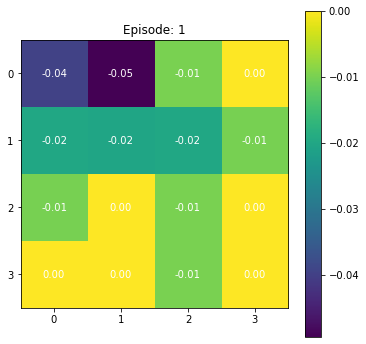

501 번째 에피소드의 TD타겟값 : -8.647291951657513


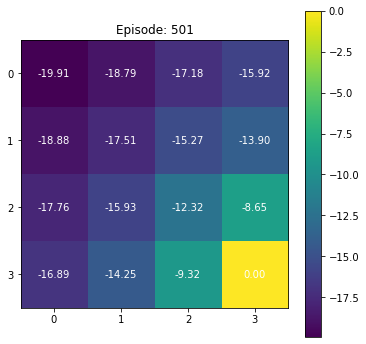

1001 번째 에피소드의 TD타겟값 : -16.851378198117974


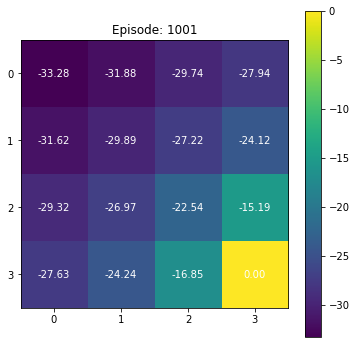

1501 번째 에피소드의 TD타겟값 : -19.7972856330097


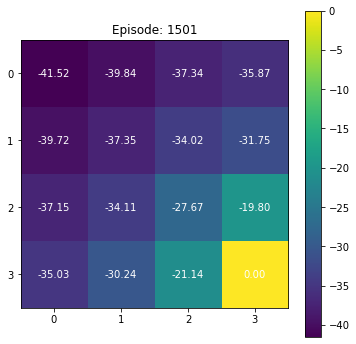

2001 번째 에피소드의 TD타겟값 : -23.20280829619404


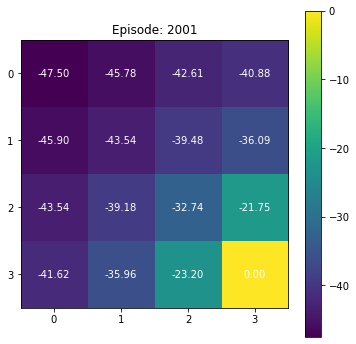

2501 번째 에피소드의 TD타겟값 : -26.48689897044055


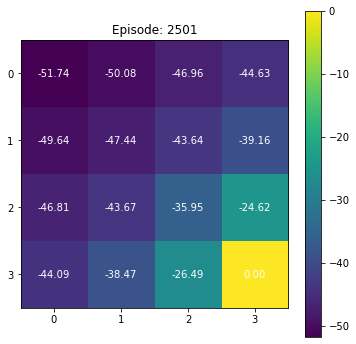

3001 번째 에피소드의 TD타겟값 : -30.02753452782864


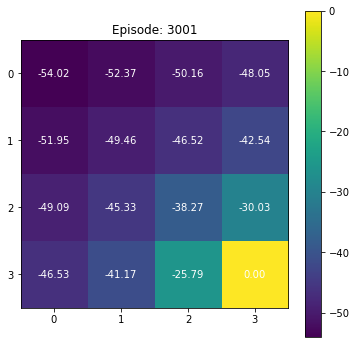

3501 번째 에피소드의 TD타겟값 : -27.595105432577412


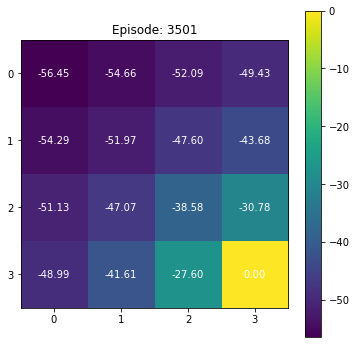

4001 번째 에피소드의 TD타겟값 : -27.931944110741128


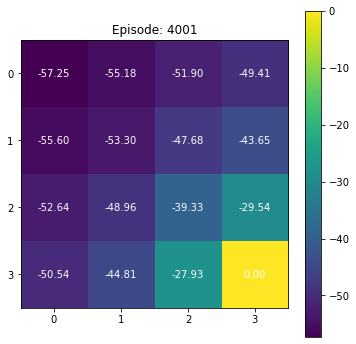

4501 번째 에피소드의 TD타겟값 : -28.029339492972294


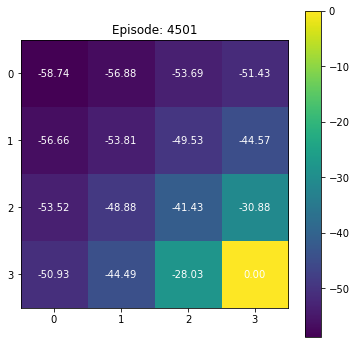

Running Time[temporal_difference]: 0.91222978 sec


In [83]:
TD_result = temporal_difference()

# 학습방법3. n-step TD

In [71]:
def n_step_temporal_difference():
    pass